This document performs topic modeling using sentence-transformers, umap, and hdbscan. 

the code is adapted from:
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6?gi=b413f0c33718

In [1]:
! pip install sentence_transformers
! pip install umap-learn
! pip install hdbscan

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 3.8 MB 24.3 MB/s 
     |████████████████████████████████| 1.2 MB 66.8 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 6.5 MB 48.1 MB/s 
     |████████████████████████████████| 895 kB 70.5 MB/s 
     |████████████████████████████████| 596 kB 84.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=c8daa7d0e0565899ae204bc3175089cd663a5adaaf0a1b24024d01f34ca43b9a
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 24.9 MB/s 
  Crea

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
quotes = pd.read_csv('drive/MyDrive/data2/mlk131quotes.csv', delimiter = '|', header = None)
data = quotes[0].tolist()
data
dfmlkwiki = pd.read_csv("drive/MyDrive/data/coding_prez/mlkwiki.csv", delimiter='|', header=None, names=['sentence', 'label'])
mlkwikistr = ' '.join(dfmlkwiki.sentence.values.astype('str'))
dfbirmjail = pd.read_csv("drive/MyDrive/data/coding_prez/birminghamjail.csv", delimiter='|', header=None, names=['sentence', 'label'])
birmjailstr = ' '.join(dfbirmjail.sentence.values.astype('str'))

In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5, # from 5. 35 for selfhelp. 70 too high
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [24]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(umap_embeddings) # from 'eom'

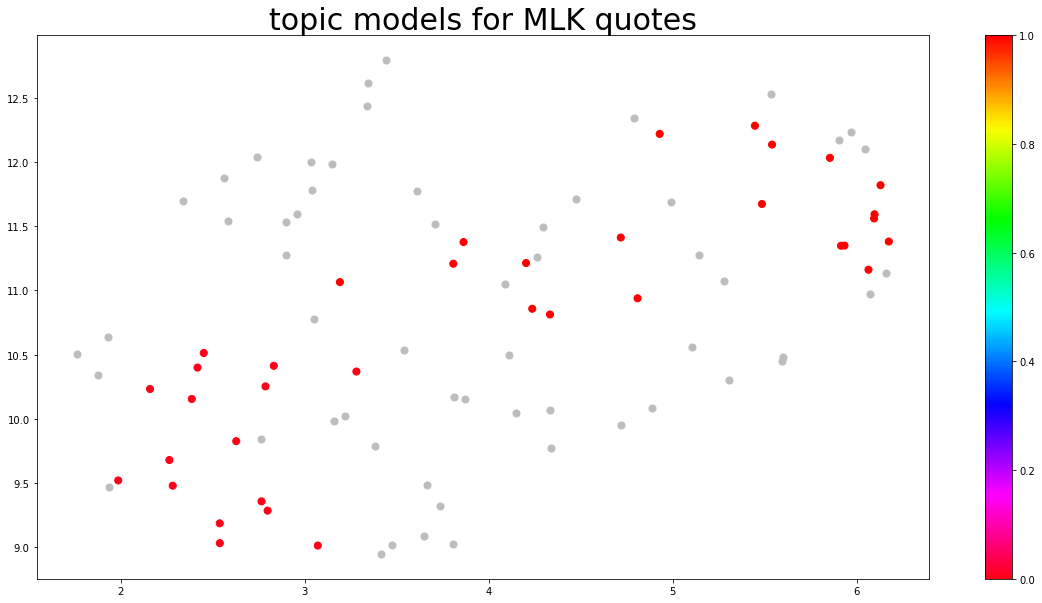

In [45]:

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings) #
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=50) # s from 0.05
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=50, cmap='hsv_r') # s from 0.05
plt.title(f'topic models for MLK quotes', fontsize = 30)
# plt.legend()
plt.colorbar()

In [35]:

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [36]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [37]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,57
2,1,20
1,0,16


In [38]:
top_n_words

{-1: [('time', 0.03502640419098236),
  ('love', 0.030715720260270064),
  ('like', 0.025507518156362617),
  ('dream', 0.025507518156362617),
  ('negro', 0.025507518156362617),
  ('man', 0.022289432887185552),
  ('serve', 0.02196373565119278),
  ('nation', 0.02196373565119278),
  ('justice', 0.021406264847063),
  ('men', 0.020406014525090093),
  ('peace', 0.020406014525090093),
  ('power', 0.02037848966681533),
  ('life', 0.01913326369232252),
  ('great', 0.01913326369232252),
  ('live', 0.01913326369232252),
  ('right', 0.0180571681961462),
  ('brotherhood', 0.017978990599398673),
  ('satisfied', 0.017978990599398673),
  ('america', 0.017978990599398673),
  ('today', 0.017978990599398673)],
 0: [('walk', 0.09078141555028434),
  ('method', 0.07816907160331342),
  ('change', 0.07816907160331342),
  ('human', 0.06398733921400894),
  ('man', 0.05666302149226851),
  ('aggression', 0.047695059783767826),
  ('foundation', 0.047695059783767826),
  ('evolve', 0.047695059783767826),
  ('rejects',

In [39]:
for topic, words in top_n_words.items():
    print([word[0] for word in words])

['time', 'love', 'like', 'dream', 'negro', 'man', 'serve', 'nation', 'justice', 'men', 'peace', 'power', 'life', 'great', 'live', 'right', 'brotherhood', 'satisfied', 'america', 'today']
['walk', 'method', 'change', 'human', 'man', 'aggression', 'foundation', 'evolve', 'rejects', 'step', 'retaliation', 'revenge', 'concerns', 'conflict', 'run', 'external', 'physical', 'force', 'rise', 'use']
['people', 'power', 'devoid', 'hate', 'right', 'stands', 'history', 'favor', 'drive', 'person', 'darkness', 'man', 'love', 'justice', 'makers', 'responsibility', 'comfort', 'tells', 'challenge', 'cast']


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,93


In [30]:
top_n_words

{-1: [('love', 0.03244259485554792),
  ('man', 0.03153022970134296),
  ('time', 0.02569141014008307),
  ('power', 0.024214716869070656),
  ('justice', 0.02260975070482415),
  ('right', 0.02086039793627373),
  ('hate', 0.018945898782893093),
  ('great', 0.018945898782893093),
  ('life', 0.018945898782893093),
  ('people', 0.018945898782893093),
  ('live', 0.018945898782893093),
  ('dream', 0.0168384883681979),
  ('devoid', 0.0168384883681979),
  ('like', 0.0168384883681979),
  ('walk', 0.0168384883681979),
  ('make', 0.0168384883681979),
  ('men', 0.0168384883681979),
  ('negro', 0.0168384883681979),
  ('peace', 0.0168384883681979),
  ('goal', 0.014499101990937168)]}

In [31]:
import pandas as pd

In [32]:
top_wordsdf = pd.DataFrame(top_n_words)
top_wordsdf
# top_wordsdf[[i for i in range(-1, 15)]]

,-1
0,"(love, 0.03244259485554792)"
1,"(man, 0.03153022970134296)"
2,"(time, 0.02569141014008307)"
3,"(power, 0.024214716869070656)"
4,"(justice, 0.02260975070482415)"
5,"(right, 0.02086039793627373)"
6,"(hate, 0.018945898782893093)"
7,"(great, 0.018945898782893093)"
8,"(life, 0.018945898782893093)"
9,"(people, 0.018945898782893093)"


In [ ]:
top_wordsdf.to_csv('drive/MyDrive/data2/topic_modeldfselfimp2.csv')

In [ ]:
top_wordsdf

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,"(doing, 0.004131396644028676)","(media, 0.026599945414376023)","(school, 0.011359564732162231)","(weight, 0.018005468177838675)","(eat, 0.015821865726645633)","(sleep, 0.036227790158063905)","(mum, 0.010951784395169252)","(women, 0.019478554259082695)","(imgur, 0.017409208347735215)","(relationship, 0.01777861529663492)","(college, 0.015017935105587382)","(group, 0.02147492849521013)","(kjv, 0.08078027001060943)","(boundaries, 0.015055170643788536)","(failure, 0.018669890442738698)","(lt, 0.08412937722268073)","(books, 0.027101703972264017)","(gt, 0.018030065676835766)"
1,"(way, 0.004120371560268698)","(instagram, 0.021528448997924145)","(college, 0.008167885733952301)","(eat, 0.017606855389904728)","(clink, 0.014826883286765251)","(bed, 0.03440657771414848)","(hate, 0.009579104074612687)","(luke, 0.012138390170607919)","(college, 0.014275517217552975)","(girl, 0.01590467281369823)","(school, 0.012424957316136463)","(min, 0.021092633636609983)","(god, 0.045503784936396736)","(say, 0.010537506898567311)","(society, 0.012839461088115425)","(div, 0.06778509814459513)","(xp, 0.025084903418909257)","(leverage, 0.016199992958416433)"
2,"(need, 0.00409682566056309)","(social, 0.016318206659288303)","(year, 0.007900564117207637)","(eating, 0.012170153501631639)","(eating, 0.013584083900539105)","(wake, 0.025243119052524)","(dad, 0.008967499567064262)","(attractive, 0.011782512516325446)","(https, 0.013611507323536628)","(dating, 0.011403025478240998)","(year, 0.01213806926203583)","(goals, 0.013773277224413794)","(lord, 0.03872096841777687)","(think, 0.0104407808105493)","(hate, 0.012691796183704262)","(gt, 0.06357079669159958)","(app, 0.022658252596473333)","(positive, 0.01207113811059212)"
3,"(lot, 0.0040834614460609295)","(games, 0.016032585577397597)","(suboxone, 0.0076921373405562645)","(food, 0.011374555955000146)","(diet, 0.01218466612746382)","(morning, 0.016919309576235924)","(family, 0.008206879441120998)","(sam, 0.011439874221961062)","(job, 0.013394649489751767)","(friend, 0.010231880817554327)","(semester, 0.011112513269519316)","(accountability, 0.013465115246204667)","(grace, 0.03661181714221488)","(defensive, 0.00994101033061225)","(failures, 0.008804511464743793)","(podcast, 0.031932127505931995)","(website, 0.022656662239063572)","(output, 0.010850490087673513)"
4,"(self, 0.004074717161855449)","(youtube, 0.015938003614536705)","(parents, 0.006927588920589654)","(smoking, 0.011287460889565528)","(healthy, 0.011480231780292493)","(night, 0.015041308844792663)","(past, 0.007465688278114163)","(funny, 0.011298951229132619)","(com, 0.010599602246859813)","(friends, 0.009168831262357966)","(job, 0.010443218369272853)","(week, 0.013010095114148749)","(corinthians, 0.036152461305539216)","(tend, 0.00987245692429645)","(angry, 0.008573140010112753)","(h2, 0.0283076831519671)","(section, 0.020573571456525157)","(self, 0.010126277081595525)"
5,"(going, 0.004063061568407173)","(facebook, 0.015214800253301462)","(friends, 0.006865124076456153)","(fat, 0.010043678844124139)","(food, 0.011235137933972426)","(sleeping, 0.013965169599782652)","(school, 0.007313175193169096)","(ladies, 0.011067356846043291)","(school, 0.010187742079093825)","(girls, 0.008859633971742093)","(graduated, 0.010380635562281722)","(write, 0.012018956717441394)","(requests, 0.034854360367120314)","(worried, 0.009828535786892975)","(desires, 0.008572608368093534)","(podcasts, 0.02808804697579116)","(improvement, 0.018838226434978757)","(goals, 0.009043231771937008)"
6,"(help, 0.004033638834819622)","(phone, 0.013660186308110021)","(old, 0.00685707133631086)","(pounds, 0.010011060012731589)","(crutches, 0.0098845888578435)","(hours, 0.013552474491810159)","(social, 0.00724229932010934)","(advice, 0.010998684563996523)","(soup, 0.009659652617339524)","(didn, 0.008574884887926022)","(studying, 0.010231228943672668)","(morning, 0.01078174160617392)","(gospel, 0.03381810949788815)","(talents, 0.009789530302766799)",